In [185]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import neural_network
import seaborn as sns
import matplotlib.cm as cm
from sklearn.model_selection import validation_curve
import os # new!

In [186]:
batch_size = 10
box_plot_title = 'Memory Estimation Error (MB)'
pd.set_option('display.max_columns', None)
# cluster_set = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

# 1. Loading training and test datasets

In [187]:
def load_data():
    df = pd.read_csv('job2_scaled_clean.csv')
    # df_test = pd.read_csv('job2_test_clean.csv')
    return df

In [188]:
df = load_data()

In [189]:
df.shape

(2332, 8)

In [190]:
df.head()

,TQ,TQ COUNT,TBSCAN,TBSCAN COUNT,HS JOIN,HS JOIN COUNT,db2,actual
0,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,521.280,251.296
1,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,251.296,251.296
2,0.081201,0.0,1.021729,0.832788,-0.055947,0.832788,251.264,251.248
3,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,251.248,251.252
4,-0.165491,0.0,0.623686,0.832788,-0.053342,0.832788,171.500,171.316


In [191]:
df.columns

Index(['TQ', 'TQ COUNT', 'TBSCAN', 'TBSCAN COUNT', 'HS JOIN', 'HS JOIN COUNT',
       'db2', 'actual'],
      dtype='object')

In [192]:
# Add queryId starting from 1
df.insert(0, 'queryId', range(1, len(df) + 1))

In [193]:
df.head()

,queryId,TQ,TQ COUNT,TBSCAN,TBSCAN COUNT,HS JOIN,HS JOIN COUNT,db2,actual
0,1,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,521.280,251.296
1,2,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,251.296,251.296
2,3,0.081201,0.0,1.021729,0.832788,-0.055947,0.832788,251.264,251.248
3,4,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,251.248,251.252
4,5,-0.165491,0.0,0.623686,0.832788,-0.053342,0.832788,171.500,171.316


# 2. Train and Evaluate a Model

In [194]:
def batch_predict(estimator, batch_size, X, Y):
    predicted = estimator.predict(X)
    Y = np.insert(Y, Y.shape[1], predicted, axis=1)
    
    indices = np.linspace(0, X.shape[0]-1, X.shape[0], dtype=int)
    np.random.seed(42)
    np.random.shuffle(indices)
    num_batches = int(np.floor(X.shape[0] / batch_size))
    
    df_batches = pd.DataFrame(columns=['actual', 'db2', 'ml'])
    
    for ibat in range(num_batches):
        start = (ibat * batch_size)
        end = (ibat * batch_size + batch_size) - 1
        
        ibat_Y = Y[indices[start:end]]
        
        actual = sum(ibat_Y[:,-1])
        db2 = sum(ibat_Y[:,-2])
        ml = sum(ibat_Y[:,-3])
        
        df_batches = df_batches.append({'actual':actual,
                                       'db2':db2,
                                       'ml':ml},
                                      ignore_index=True)
        
    return df_batches

def rmse(Y):
    cols = Y.columns.values[1:]
    rmse_dict = {}
    
    for col in cols:
        rmse = np.round(np.sqrt(mean_squared_error(Y['actual'].values, Y[col].values)))
        rmse_dict[col] = rmse
    
    return rmse_dict
    
def calculate_residuals(Y):
    first_col = Y.columns[0]
    cols = Y.columns[1:]
    df_residuals = pd.DataFrame(columns=cols)

    for col in cols:
        df_residuals[col] = Y[col] - Y[first_col]
        
    return df_residuals

def box_plot(Y, length, height):
    df_residuals = calculate_residuals(Y)
    sns.set_style("whitegrid", {'axes.grid' : False})
    f = plt.figure(figsize=[length,height])
    plt.rcParams.update({'font.size': 16})
    ax = f.add_subplot(111)
    sns.boxplot(data=df_residuals, ax=ax, showfliers = True, orient="h")
    ax.set_xlabel(xlabel=box_plot_title,fontsize=22)
    plt.tick_params(axis='x',labeltop='on', labelbottom='on')
    ax.xaxis.set_ticks_position('both')
    #ax.set_yticks(yticks_new)
#     plt.setp(ax.get_yticklabels(), rotation=90)
    f.tight_layout()
    plt.show()
    ax.savefig('job_err.png')
def residual_plot(Y):
    Y_predicted = Y.iloc[:,1:]
    print('Y_predicted ', Y_predicted.shape)
    cols = Y_predicted.columns
    markers = ['8', 'P', '*', 'h', 'X','+','^','s','o']
#     colors = ['steelblue', 'darkorange', 'darkorchid', 'limegreen', 'fuchsia']
    colors = cm.rainbow(np.linspace(0, 1, len(cols)))
    
    Y_residuals = calculate_residuals(Y)
    print('Y_residuals ', Y_residuals.shape)
    
    for col in cols:
        plot_index = Y_predicted.columns.get_loc(col)
        plt.scatter(Y_predicted[col], Y_residuals[col], 
                   edgecolor='white', c=colors[plot_index],
                   marker=markers[plot_index], label=col)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=0, xmax=9000, color='black', lw=2)
    plt.xlim([0, 9000])
    plt.tight_layout()
    plt.show()
    
def create_workload(batch_size, data):
    # Select relevant columns
    df_data = data[['queryId', 'db2', 'actual', 'cluster']]
    
    labels = df_data['cluster'].unique()
    labels = np.sort(labels)
    cluster_columns = [f"cluster_{int(c)}" for c in labels]
    
    # Break view link if any filtering
    df_data = df_data.copy()
    df_data.loc[:, "cluster"] = df_data["cluster"].astype("int64")

    df_data = pd.get_dummies(df_data, columns=["cluster"], dtype=int)

    missing_columns = [col for col in cluster_columns if col not in df_data.columns]
    if missing_columns:
        df_missing = pd.DataFrame(0, index=df_data.index, columns=missing_columns)
        df_data = pd.concat([df_data, df_missing], axis=1)

    # Sort columns
    df_data = df_data.reindex(columns=['queryId', 'db2', 'actual'] + cluster_columns)
    
    # Initialize batches
    df_batches = []
    query_ids_per_batch = []  # 👈 list to track query IDs
    indices = np.arange(len(df_data))
    num_batches = len(df_data) // batch_size
    
    # Create batches
    for ibat in range(num_batches):
        batch_indices = indices[ibat * batch_size:(ibat + 1) * batch_size]
        ibat_Y = df_data.iloc[batch_indices]

        df_batches.append(ibat_Y.drop(columns=['queryId']).sum())  # drop queryId before summing
        query_ids_per_batch.append(ibat_Y['queryId'].tolist())     # 👈 save queryIds separately

    # Combine batches into a DataFrame
    batches_df = pd.DataFrame(df_batches)

    return batches_df, query_ids_per_batch

# Clustering 

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

def get_clusters(k, data, km=None, test_size=0.3, min_rows_per_cluster=10, random_state=42):
    # Split data
    train_data, test_data = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state,
        shuffle=True
    )

    # Features only (drop queryId, db2, actual)
    X_train = train_data.drop(columns=['queryId', 'db2', 'actual'])
    X_test = test_data.drop(columns=['queryId', 'db2', 'actual'])

    # Train KMeans once
    if km is not None:
        print('Using provided clustering model')
    else:
        print('Training initial clustering model')
        km = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=random_state
        )
        km.fit(X_train)

    # Predict initial cluster assignments
    initial_train_clusters = km.predict(X_train)

    # Find which clusters to keep
    cluster_counts = pd.Series(initial_train_clusters).value_counts()
    keep_clusters = cluster_counts[cluster_counts >= min_rows_per_cluster].index.tolist()
    print(f"Kept {len(keep_clusters)} clusters after pruning (≥ {min_rows_per_cluster} members each)")

    # Keep only centroids of valid clusters
    kept_centroids = km.cluster_centers_[keep_clusters]

    # Function to assign rows to nearest kept centroid
    def assign_to_kept_centroids(X, kept_centroids):
        distances = cdist(X, kept_centroids, metric='euclidean')  # shape: (n_samples, n_kept_clusters)
        nearest_cluster_indices = np.argmin(distances, axis=1)    # which centroid is nearest
        return nearest_cluster_indices

    # Predict final labels for full train and test sets
    relabeled_train_clusters = assign_to_kept_centroids(X_train, kept_centroids)
    relabeled_test_clusters = assign_to_kept_centroids(X_test, kept_centroids)

    # Relabel clusters starting from 1
    relabeled_train_clusters += 1
    relabeled_test_clusters += 1

    # Prepare final DataFrames
    train_df = train_data.copy()
    train_df['cluster'] = relabeled_train_clusters.astype('int64')

    test_df = test_data.copy()
    test_df['cluster'] = relabeled_test_clusters.astype('int64')

    # Report
    print('Distortion (Training Inertia): %.2f' % km.inertia_)

    return train_df, test_df

# Workload

In [196]:
df.shape

(2332, 9)

In [197]:
k = 50
df_train, df_test = get_clusters(k, df, None)

Training initial clustering model
Kept 21 clusters after pruning (≥ 10 members each)
Distortion (Training Inertia): 0.00


In [198]:
df_train.head()

,queryId,TQ,TQ COUNT,TBSCAN,TBSCAN COUNT,HS JOIN,HS JOIN COUNT,db2,actual,cluster
1435,1436,-0.165195,0.0,-1.189377,-1.200785,-0.061716,-1.200785,526.412,39.804,3
1094,1095,-0.165218,0.0,-1.189377,-1.200785,-0.061757,-1.200785,526.412,39.804,3
1909,1910,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,251.248,251.256,6
1347,1348,-0.166149,0.0,-1.189379,-1.200785,-0.063493,-1.200785,532.864,49.364,1
436,437,-0.157906,0.0,-1.189365,-1.200785,-0.058484,-1.200785,532.864,72.584,11


In [199]:
df_train["cluster"].nunique()

21

In [200]:
df_train['cluster'].value_counts()

cluster
1     326
2     181
3     156
4     111
5     108
19     96
6      89
7      83
8      72
9      56
10     53
11     49
12     41
13     37
14     34
15     32
16     27
17     25
20     24
18     22
21     10
Name: count, dtype: int64

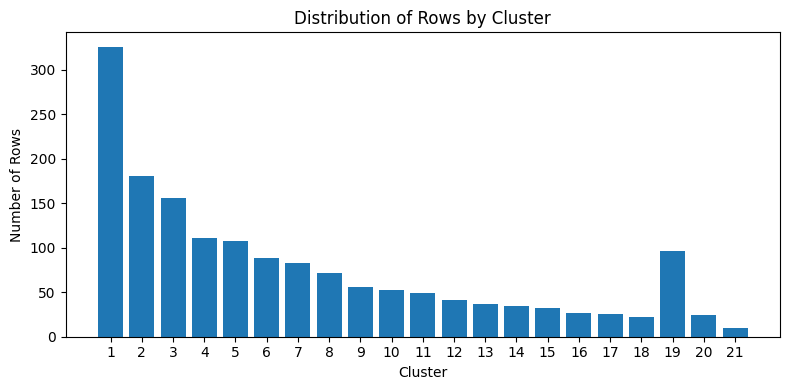

In [201]:
import matplotlib.pyplot as plt

# Count the number of rows in each cluster
cluster_counts = df_train["cluster"].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 4))
plt.bar(cluster_counts.index, cluster_counts.values)

# Add labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Rows")
plt.title("Distribution of Rows by Cluster")
plt.xticks(cluster_counts.index)

# Show the plot
plt.tight_layout()
plt.show()

# Create Workloads

In [202]:
df_train.columns

Index(['queryId', 'TQ', 'TQ COUNT', 'TBSCAN', 'TBSCAN COUNT', 'HS JOIN',
       'HS JOIN COUNT', 'db2', 'actual', 'cluster'],
      dtype='object')

In [203]:
# import os

# # Ensure the folder exists
# output_folder = "cluster_data"
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)
    
df_train_workloads, train_query_ids_per_batch = create_workload(batch_size, df_train)
df_test_workloads, test_query_ids_per_batch = create_workload(batch_size, df_test)

In [204]:
df_train_workloads.shape

(163, 23)

In [205]:
len(train_query_ids_per_batch)

163

In [206]:
train_query_ids_per_batch[0]

[1436, 1095, 1910, 1348, 437, 1858, 1473, 394, 1669, 535]

In [207]:
df_test_workloads.shape

(70, 22)

In [208]:
# Find columns that are missing in test
missing_cols = set(df_train_workloads.columns) - set(df_test_workloads.columns)

# Add missing columns with value 0
for col in missing_cols:
    df_test_workloads[col] = 0

# Reorder columns to match train
df_test_workloads = df_test_workloads[df_train_workloads.columns]

In [209]:
df_test_workloads.shape

(70, 23)

In [210]:
df_train_workloads.head()

,db2,actual,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21
0,4174.168,1320.804,1.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2901.112,1979.508,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3728.804,1299.784,2.0,2.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3496.012,1099.360,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2664.076,1690.100,2.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
df_test_workloads.head()

,db2,actual,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21
0,3178.504,1735.248,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0
1,3618.472,1759.204,1.0,0.0,2.0,3.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,3177.276,1879.144,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,3460.208,1565.284,2.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
4,3184.928,1741.064,3.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0


In [212]:
df_test_workloads.columns

Index(['db2', 'actual', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
       'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14',
       'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19',
       'cluster_20', 'cluster_21'],
      dtype='object')

In [213]:
df_test_workloads.shape

(70, 23)

align the two frames on their columns and tell pandas to fill anything that’s missing with 0

In [214]:

def load_train_data():
    df = df_train_workloads
    
    feature_cols = [col for col in df.columns if col.startswith('cluster_')]    
    print(feature_cols)

    target_col = ['actual']
    
    X = df[feature_cols]
    y = df[target_col].values.ravel()  # Flatten y to 1D
    
    print('X.shape: ', X.shape)
    print('y.shape: ', y.shape)
    
    return X.values, y


def load_test_data():
    df = df_test_workloads
  
    # Assuming `df` is your DataFrame
    feature_cols = [col for col in df.columns if col.startswith('cluster_')]
    print(feature_cols)
    
    target_cols = ['db2', 'actual']
    
    X = df[feature_cols]
    Y = df[target_cols]
    
    print('X.shape: ', X.shape)
    print('y.shape: ', Y.shape)
    
    return X, Y, test_query_ids_per_batch

def my_validation_curve(estimator_name, estimator, param_name, param_range):
    train_scores, valid_scores = validation_curve(estimator, X, y, param_name=param_name,
        param_range=param_range, cv=10, scoring="neg_mean_squared_error",
    )

    train_scores = np.sqrt(np.abs(train_scores))
    valid_scores = np.sqrt(np.abs(valid_scores))
    
    print(len(train_scores))
    print(len(valid_scores))

    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    
    title_str = "Validation Curve with " + estimator_name
    plt.title(title_str)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.plot(param_range, train_scores_mean, label="train rmse")
    plt.plot(param_range, valid_scores_mean, label="validation rmse")

    plt.legend(loc='lower right')
    plt.show()
    
    train_rmse = [round(elem, 2) for elem in train_scores_mean]
    valid_rmse = [round(elem, 2) for elem in valid_scores_mean]
    
    df_scores = pd.DataFrame({'param': param_range, 'train_rmse': train_rmse, 'valid_rmse': valid_rmse})
    print(df_scores)
    
from sklearn.metrics import mean_squared_error
import numpy as np

def cross_validate(model):
    # Load data
    X, y = load_train_data()
    train_data = X.copy()
    train_targets = y.copy()

    # k = 10
    num_val_samples = len(train_data) // k
    all_train_scores = []
    all_scores = []
    
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                             train_data[(i + 1) * num_val_samples:]], axis=0)
        
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                                train_targets[(i + 1) * num_val_samples:]], axis=0)

        model.fit(partial_train_data, partial_train_targets)
    
        train_mse = mean_squared_error(partial_train_targets, model.predict(partial_train_data))
        val_mse = mean_squared_error(val_targets, model.predict(val_data))
    
        all_train_scores.append(train_mse)
        all_scores.append(val_mse)
    
    train_rmse = np.sqrt(np.mean(all_train_scores))
    val_rmse = np.sqrt(np.mean(all_scores))

    print('train rmse:', train_rmse)
    print('validation rmse:', val_rmse)

    return train_rmse, val_rmse

In [215]:
X, y = load_train_data()

['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21']
X.shape:  (163, 21)
y.shape:  (163,)


In [216]:
rmse_scores = {}

# Ridge Cross-Validate

In [217]:
ridge = Ridge(
        fit_intercept=True, 
        solver='lsqr',
        alpha = 1.0,
        random_state=42)

rmse_scores['Ridge'] = cross_validate(ridge)
# ridge.fit(X, y)

['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21']
X.shape:  (163, 21)
y.shape:  (163,)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
Processing fold #10
Processing fold #11
Processing fold #12
Processing fold #13
Processing fold #14
Processing fold #15
Processing fold #16
Processing fold #17
Processing fold #18
Processing fold #19
Processing fold #20
Processing fold #21
Processing fold #22
Processing fold #23
Processing fold #24
Processing fold #25
Processing fold #26
Processing fold #27
Processing fold #28
Processing fold #29
Processing fold #30
Processing fold #31
Processing fold #32
Processing fold #33
Process

# Decision Tree Regression - Tuning max_features

In [218]:
tree = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=0.23,
    random_state=33,
)

rmse_scores['Decision Tree'] = cross_validate(tree)

tree.fit(X, y)

['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21']
X.shape:  (163, 21)
y.shape:  (163,)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
Processing fold #10
Processing fold #11
Processing fold #12
Processing fold #13
Processing fold #14
Processing fold #15
Processing fold #16
Processing fold #17
Processing fold #18
Processing fold #19
Processing fold #20
Processing fold #21
Processing fold #22
Processing fold #23
Processing fold #24
Processing fold #25
Processing fold #26
Processing fold #27
Processing fold #28
Processing fold #29
Processing fold #30
Processing fold #31
Processing fold #32
Processing fold #33
Process

DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.23, min_samples_split=4,
                      random_state=33)

# Forest final model - using tuned HP from AutoAI

In [219]:
forest = RandomForestRegressor(
    max_depth=5,
    max_features=0.6109469920813564,
    min_samples_leaf=4,
    min_samples_split=5,
    n_estimators=17,
    #n_jobs=CPU_NUMBER,
    random_state=33,
)

rmse_scores['Random Forest'] = cross_validate(forest)

forest.fit(X, y)

['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21']
X.shape:  (163, 21)
y.shape:  (163,)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
Processing fold #10
Processing fold #11
Processing fold #12
Processing fold #13
Processing fold #14
Processing fold #15
Processing fold #16
Processing fold #17
Processing fold #18
Processing fold #19
Processing fold #20
Processing fold #21
Processing fold #22
Processing fold #23
Processing fold #24
Processing fold #25
Processing fold #26
Processing fold #27
Processing fold #28
Processing fold #29
Processing fold #30
Processing fold #31
Processing fold #32
Processing fold #33
Process

RandomForestRegressor(max_depth=5, max_features=0.6109469920813564,
                      min_samples_leaf=4, min_samples_split=5, n_estimators=17,
                      random_state=33)

# XGB Regressor

In [220]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(
    # --- general ----------------------------------------------------------
    objective="reg:squarederror",        # default for regression
    base_score=0.5,
    booster="gbtree",
    random_state=33,                     # controls all randomness
    seed=33,                             # still accepted (alias for random_state)

    # --- tree construction ------------------------------------------------
    tree_method="hist",                  # faster than "exact" on most CPUs
    device="cpu",                        # set to "cuda" for GPU training ➊
    n_jobs=1,                            # threads (was `nthread`) ➋
    n_estimators=879,
    learning_rate=0.1814227666290778,
    max_depth=1,
    min_child_weight=2,
    max_delta_step=0,

    # --- column / row sampling -------------------------------------------
    subsample=0.04694370939809412,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,

    # --- regularisation ---------------------------------------------------
    gamma=0.0,                           # alias for `min_split_loss`
    reg_alpha=1.0,
    reg_lambda=0.40529327440922186,

    # --- misc -------------------------------------------------------------
    interaction_constraints="",
    monotone_constraints="()",
    num_parallel_tree=1,
    scale_pos_weight=1,
    verbosity=0,                         # replaces deprecated `silent` ➌
    validate_parameters=True,            # still supported ➍
)


rmse_scores['XGBoost'] = cross_validate(xgb_regressor)

xgb_regressor.fit(X, y)

['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21']
X.shape:  (163, 21)
y.shape:  (163,)
Processing fold #0
Processing fold #1


Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
Processing fold #10
Processing fold #11
Processing fold #12
Processing fold #13
Processing fold #14
Processing fold #15
Processing fold #16
Processing fold #17
Processing fold #18
Processing fold #19
Processing fold #20
Processing fold #21
Processing fold #22
Processing fold #23
Processing fold #24
Processing fold #25
Processing fold #26
Processing fold #27
Processing fold #28
Processing fold #29
Processing fold #30
Processing fold #31
Processing fold #32
Processing fold #33
Processing fold #34
Processing fold #35
Processing fold #36
Processing fold #37
Processing fold #38
Processing fold #39
Processing fold #40
Processing fold #41
Processing fold #42
Processing fold #43
Processing fold #44
Processing fold #45
Processing fold #46
Processing fold #47
Processing fold #48
Processing fold #49
train rmse: 64.8260790453136
validation rmse: 81

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device='cpu', early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints='', learning_rate=0.1814227666290778,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=0, max_depth=1, max_leaves=None, min_child_weight=2,
             missing=nan, monotone_constraints='()', multi_strategy=None,
             n_estimators=879, n_jobs=1, num_parallel_tree=1, ...)

# Deep Neural Network (DNN)

In [221]:
from sklearn.neural_network import MLPRegressor

dnn_model = dnn_model = MLPRegressor(max_iter=500,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
rmse_scores['DNN'] = cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21']
X.shape:  (163, 21)
y.shape:  (163,)
Processing fold #0


Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
Processing fold #10
Processing fold #11
Processing fold #12
Processing fold #13
Processing fold #14
Processing fold #15
Processing fold #16
Processing fold #17
Processing fold #18
Processing fold #19
Processing fold #20
Processing fold #21
Processing fold #22
Processing fold #23
Processing fold #24
Processing fold #25
Processing fold #26
Processing fold #27
Processing fold #28
Processing fold #29
Processing fold #30
Processing fold #31
Processing fold #32
Processing fold #33
Processing fold #34
Processing fold #35
Processing fold #36
Processing fold #37
Processing fold #38
Processing fold #39
Processing fold #40
Processing fold #41
Processing fold #42
Processing fold #43
Processing fold #44
Processing fold #45
Processing fold #46
Processing fold #47
Processing fold #48
Processing fold #49
train rmse: 43.03656760140732

MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=500,
             random_state=6, solver='lbfgs')

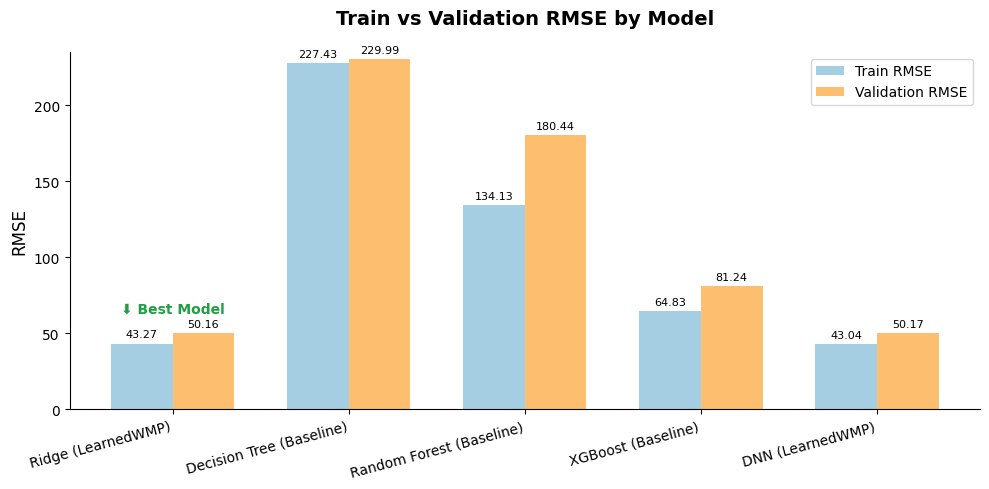

In [222]:
import matplotlib.pyplot as plt

# Extract model names and RMSE values
model_names = list(rmse_scores.keys())
train_rmses = [rmse_scores[model][0] for model in model_names]
val_rmses = [rmse_scores[model][1] for model in model_names]

# Update model labels
label_mapping = {
    'Ridge': 'Ridge (LearnedWMP)',
    'Decision Tree': 'Decision Tree (Baseline)',
    'Random Forest': 'Random Forest (Baseline)',
    'XGBoost': 'XGBoost (Baseline)',
    'DNN': 'DNN (LearnedWMP)'
}
model_names = [label_mapping.get(name, name) for name in model_names]

# Identify the best model (lowest validation RMSE)
best_index = val_rmses.index(min(val_rmses))

# Plot setup
x = range(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))

# Setup consistent colors
train_color = '#a6cee3'  # light blue for Train RMSE
val_color = '#fdbf6f'    # light orange for Validation RMSE

# Draw bars
train_bars = ax.bar([i - width/2 for i in x], train_rmses, width, label='Train RMSE', color=train_color)
val_bars = ax.bar([i + width/2 for i in x], val_rmses, width, label='Validation RMSE', color=val_color)

# Add RMSE value labels on top of bars
for bar_group in [train_bars, val_bars]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Find minimum of train and validation RMSE for best model
best_bar_height = min(train_rmses[best_index], val_rmses[best_index])

# Annotate above the bar, move slightly higher
ax.annotate(
    '⬇ Best Model',
    xy=(best_index, best_bar_height),
    xytext=(0, 20),      # 🔵 move 20 points above
    textcoords='offset points',
    ha='center',
    va='bottom',
    fontsize=10,
    color='#1f9e44',
    fontweight='bold'
)


# Formatting and labels
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Train vs Validation RMSE by Model', fontsize=14, weight='bold', pad=20)
ax.set_xticks(list(x))
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()

# Remove grid lines
ax.grid(False)

# Remove top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust y-limits
ax.set_ylim(
    bottom=0,  # start at 0 now (no need for negative values)
    top=max(max(train_rmses), max(val_rmses)) + 5
)

plt.tight_layout()
plt.show()

In [224]:
ridge.fit(X, y)

Ridge(random_state=42, solver='lsqr')

In [239]:
X_test, Y_test, list_query_ids = load_test_data()

['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21']
X.shape:  (70, 21)
y.shape:  (70, 2)


In [240]:
X_test.shape

(70, 21)

In [241]:
Y_test.shape

(70, 2)

In [242]:
X_test.head()

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,2.0,3.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,2.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
4,3.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0


In [243]:
len(test_query_ids_per_batch)

70

In [244]:
Y_test = Y_test.copy()
Y_test['ridge'] = ridge.predict(X_test.values)

In [245]:
# Ensure 'actual' is the first column
cols = ['actual'] + [col for col in Y_test.columns if col != 'actual']
Y_test = Y_test[cols]

In [246]:
Y_test.head()

,actual,db2,ridge
0,1735.248,3178.504,1779.502421
1,1759.204,3618.472,1736.748512
2,1879.144,3177.276,1771.603993
3,1565.284,3460.208,1569.541472
4,1741.064,3184.928,1748.839593


In [247]:
Y_test.columns

Index(['actual', 'db2', 'ridge'], dtype='object')

In [249]:
import numpy as np
import pandas as pd

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Assume Y_test is a DataFrame with 'actual', 'db2', 'dnn'

# MAPE for db2
mape_db2 = mean_absolute_percentage_error(Y_test['actual'], Y_test['db2'])

# MAPE for dnn
mape_dnn = mean_absolute_percentage_error(Y_test['actual'], Y_test['ridge'])

print(f"MAPE (db2): {mape_db2:.3f}%")
print(f"MAPE (ridge): {mape_dnn:.3f}%")

MAPE (db2): 131.072%
MAPE (ridge): 2.454%


# Comparing Db2 vs Ridge

In [250]:
import pandas as pd
import numpy as np

# Assume Y_test is your DataFrame

# Calculate absolute errors for each method
Y_test['db2_error'] = np.abs(Y_test['db2'] - Y_test['actual'])
Y_test['ridge_error'] = np.abs(Y_test['ridge'] - Y_test['actual'])

# Compare which method is better for each example
db2_better = Y_test[Y_test['db2_error'] < Y_test['ridge_error']]
ridge_better = Y_test[Y_test['ridge_error'] < Y_test['db2_error']]

# (Optional) Print some results
print(f"Number of examples where DB2 is better: {len(db2_better)}")
print(f"Number of examples where Ridge is better: {len(ridge_better)}")

# (Optional) View
# print(db2_better[['actual', 'db2', 'ridge', 'db2_error', 'ridge_error']])
# print(ridge_better[['actual', 'db2', 'ridge', 'db2_error', 'ridge_error']])


Number of examples where DB2 is better: 0
Number of examples where Ridge is better: 70
